## Import Packages

In [1]:
import matplotlib
import matplotlib.pyplot as plt

import math
import gym
import numpy as np
import copy
import pandas as pd
import seaborn as sns
import time

import imageio

import IPython
from IPython.display import Image

import sys, subprocess
import time

from State import State
from Movement_evaluation import evaluate_by_gravity
import numpy as np
import random
import time
from Ball import Ball
from Config import *
from Game import Game

In [2]:
sns.set_context("talk")

# Logistic Regression Agent

In [5]:
def sigmoid(x):
    """
    x: float
    """
    return 1.0 / (1.0 + np.exp(-x))


def logistic_regression(s, theta):
    """
    s: State
    theta: np.array, with the same dimension as the vectorized state
    """
    left2right_proportion = sigmoid(np.dot(s.vectorize(), np.transpose(theta)))
    return left2right_proportion


def draw_action(s, theta):
    return int(s.screen_x * logistic_regression(s, theta))

In [6]:
class LogisticRegression:

    def __init__(self, game):        
        self.num_params = len(game.current_state.vectorize())

    def __call__(self, state, theta):
        return draw_action(state, theta)
    

class LogisticRegressionAgent(object):
    
    def __init__(self, theta):
        self.theta = theta
    
    def get_action(self, state):
        return draw_action(state, self.theta)

In [3]:
def play_one_episode(game, agent, max_step = None, plot = False):
    is_finish = False
    current_state = game.init_state()
    reward_recorder = []
    step = 1

    while not is_finish:
        action = agent.get_action(current_state)
        next_state, reward, is_finish = game.next_step(action, verbose = False)
        if plot:
            next_state.plot_state()
        reward_recorder.append(reward)
        current_state = next_state
        step += 1
        if max_step and step >= max_step:
            break
    
    return reward_recorder[-1], reward_recorder, game.current_reward

# 1+1 Self-Adaptation Evolution Strategy: (1+1)-SA-ES

In [7]:
class ObjectiveFunction:

    def __init__(self, game, policy, num_episodes=1, max_time_steps=float('inf'), minimization_solver=True):
        self.ndim = policy.num_params  # Number of dimensions of the parameter (weights) space
        self.game = game
        self.policy = policy
        self.num_episodes = num_episodes
        self.max_time_steps = max_time_steps
        self.minimization_solver = minimization_solver

        self.num_evals = 0

        
    def eval(self, policy_params, num_episodes=None, max_time_steps=None, render=False):
        """Evaluate a policy"""

        self.num_evals += 1

        if num_episodes is None:
            num_episodes = self.num_episodes

        if max_time_steps is None:
            max_time_steps = self.max_time_steps

        average_total_rewards = 0

        for i_episode in range(num_episodes):

            total_rewards = 0.
            state = self.game.init_state()
            self.game.is_finish = False
            for t in range(max_time_steps):
                if render:
                    self.game.current_state.plot_state(is_plt=True)

                action = self.policy(state, policy_params)
                
                state, reward, is_finish = self.game.next_step(action, verbose = False)
                total_rewards = reward
                
                if is_finish:
                    break

            average_total_rewards += float(total_rewards) / num_episodes

            if render:
                print("Test Episode {0}: Total Reward = {1}".format(i_episode, total_rewards))

        if self.minimization_solver:
            average_total_rewards *= -1.

        return average_total_rewards   # Optimizers do minimization by default...

    
    def __call__(self, policy_params, num_episodes=None, max_time_steps=None, render=False):
        return self.eval(policy_params, num_episodes, max_time_steps, render)

In [10]:
# Implement another method

def saes_1_1(objective_function,
             x_array,
             sigma_array,
             max_iterations=500,
             tau=None,
             print_every=10,
             success_score=float("inf"),
             num_evals_for_stop=None,
             hist_dict=None):
    score = objective_function(x_array, num_episodes=num_evals_for_stop)
    for i in range(max_iterations):
        sigma_new = sigma_array * np.exp(tau*np.random.randn(objective_function.policy.num_params))
        x_new = x_array + sigma_new*np.random.randn(objective_function.policy.num_params)
        score_new = objective_function(x_new, num_episodes=num_evals_for_stop)
        if score_new <= score:
            x_array = x_new
            sigma_array = sigma_new
            score = score_new
            np.save( "theta_seas.npy", x_array )
        if i % print_every == 0:
            print("Iteration {}\tScore {}".format(i, score))
            print("x array: ", x_array)
            print("sigma array: ", sigma_array)
        if hist_dict is not None:
            hist_dict[i] = [score] + x_array.tolist() + sigma_array.tolist()
        if score <= success_score:
            break
        if np.max(np.abs(sigma_array)) < 10 ** -3:
            break

    return x_array

In [11]:
game = Game(screen_x, screen_y, end_line, balls_setting, max_random_ball_level)

nn_policy = LogisticRegression(game)

objective_function = ObjectiveFunction(game=game,
                                       policy=nn_policy,
                                       num_episodes=3,
                                       max_time_steps=200)

In [12]:
# Training

hist_dict = {}

init_x_array = np.random.random(nn_policy.num_params) - 0.5
init_sigma_array = np.random.random(nn_policy.num_params) * 0.2

theta = saes_1_1(objective_function=objective_function,
             x_array=init_x_array,
             sigma_array=init_sigma_array,
             max_iterations=50,
             tau=0.01,
             print_every=1,
             success_score=-800,
             num_evals_for_stop=3,
             hist_dict=hist_dict)

The game is finish, final score is 243
The game is finish, final score is 311
The game is finish, final score is 219
The game is finish, final score is 341
The game is finish, final score is 181
The game is finish, final score is 235
Iteration 0	Score -257.6666666666667
x array:  [-0.04736463 -0.05774461  0.13094787  0.40864712 -0.32016507  0.136147
 -0.23876635 -0.35942075 -0.18430445 -0.4026455  -0.17688511 -0.01869475
  0.28534804 -0.00093158 -0.39667859  0.27687604 -0.31863163 -0.07863116
 -0.45415553 -0.06383522 -0.13079532 -0.02639467  0.13923869  0.34182802
 -0.17669801 -0.18815245 -0.40622679 -0.21829494 -0.19955223 -0.30609944
  0.43337531]
sigma array:  [0.1235749  0.06730991 0.05154726 0.07917345 0.14883653 0.12973437
 0.19817655 0.1498841  0.09644785 0.02685473 0.03552996 0.1075795
 0.00556876 0.11288208 0.19074057 0.00442286 0.13090538 0.02689068
 0.05594241 0.17769813 0.02690626 0.19410203 0.178946   0.19399424
 0.19440306 0.13181419 0.02568391 0.10624918 0.14426548 0.019

The game is finish, final score is 243
The game is finish, final score is 240
The game is finish, final score is 151
Iteration 9	Score -267.6666666666667
x array:  [-0.3355752  -0.04814861  0.11261614  0.45041701 -0.16105364  0.22389808
 -0.53373571 -0.50533662 -0.38893263 -0.39863664 -0.16613456  0.02235671
  0.28846588  0.13375433 -0.61258108  0.27613992 -0.41614561 -0.09151191
 -0.47563861 -0.03836855 -0.15330898 -0.07393977  0.14973876  0.18415693
 -0.2631356  -0.07929321 -0.43911105 -0.29965345 -0.14194647 -0.31441057
  0.21979181]
sigma array:  [0.12371185 0.06721811 0.05114121 0.07930785 0.1485046  0.13035235
 0.19954003 0.14989106 0.09736347 0.02737899 0.03572288 0.10636716
 0.0055717  0.11302271 0.1914417  0.00444802 0.13114502 0.02669017
 0.05675194 0.17809634 0.02705772 0.19568651 0.18079965 0.19390476
 0.19461252 0.13104302 0.02593847 0.1066464  0.14203688 0.01938898
 0.14714904]
The game is finish, final score is 192
The game is finish, final score is 291
The game is finis

The game is finish, final score is 261
The game is finish, final score is 225
The game is finish, final score is 160
Iteration 19	Score -281.0
x array:  [-0.47366796 -0.00939644  0.16527768  0.48007858 -0.2041741   0.39078524
 -0.76797227 -0.32646979 -0.39535656 -0.41806545 -0.16662342 -0.22725607
  0.284824    0.35243719 -0.5344307   0.27298123 -0.53069574 -0.04817647
 -0.43283914  0.09766116 -0.14119231 -0.31921707  0.36135778  0.02372033
  0.1754298   0.24777812 -0.44988404 -0.53463974 -0.383426   -0.31015503
  0.17371356]
sigma array:  [0.12481242 0.06693789 0.05141767 0.0777604  0.14941653 0.13107262
 0.19741167 0.15057772 0.09618435 0.02727331 0.03610889 0.1064199
 0.00559195 0.11448972 0.19044875 0.00447903 0.13006808 0.02686045
 0.05633574 0.17792306 0.02653052 0.19660974 0.17798543 0.19309714
 0.19336048 0.13009862 0.02592714 0.10569706 0.142208   0.01970803
 0.1473846 ]
The game is finish, final score is 221
The game is finish, final score is 254
The game is finish, final sco

The game is finish, final score is 212
The game is finish, final score is 255
The game is finish, final score is 203
Iteration 29	Score -281.0
x array:  [-0.47366796 -0.00939644  0.16527768  0.48007858 -0.2041741   0.39078524
 -0.76797227 -0.32646979 -0.39535656 -0.41806545 -0.16662342 -0.22725607
  0.284824    0.35243719 -0.5344307   0.27298123 -0.53069574 -0.04817647
 -0.43283914  0.09766116 -0.14119231 -0.31921707  0.36135778  0.02372033
  0.1754298   0.24777812 -0.44988404 -0.53463974 -0.383426   -0.31015503
  0.17371356]
sigma array:  [0.12481242 0.06693789 0.05141767 0.0777604  0.14941653 0.13107262
 0.19741167 0.15057772 0.09618435 0.02727331 0.03610889 0.1064199
 0.00559195 0.11448972 0.19044875 0.00447903 0.13006808 0.02686045
 0.05633574 0.17792306 0.02653052 0.19660974 0.17798543 0.19309714
 0.19336048 0.13009862 0.02592714 0.10569706 0.142208   0.01970803
 0.1473846 ]
The game is finish, final score is 150
The game is finish, final score is 204
The game is finish, final sco

The game is finish, final score is 305
Iteration 38	Score -300.6666666666667
x array:  [-0.17347992  0.01946562  0.14118439  0.49587182 -0.14035769  0.24354214
 -0.88125905 -0.23067713 -0.34452019 -0.38060918 -0.13394781 -0.27220741
  0.28481555  0.31588164 -0.47377252  0.26954651 -0.30056712 -0.08617615
 -0.50259778  0.14790878 -0.12882115 -0.13934326  0.39708958 -0.08596806
  0.17215305  0.2216818  -0.44739352 -0.57419701 -0.41808605 -0.28032875
  0.10737163]
sigma array:  [0.1255768  0.06717261 0.05181607 0.07734935 0.14992742 0.13317095
 0.19943212 0.15186422 0.09664075 0.0272199  0.03599525 0.10487934
 0.00558947 0.11299122 0.18939862 0.00442863 0.13019962 0.02695587
 0.05641541 0.17871317 0.02625926 0.1977685  0.17848757 0.19430896
 0.19180468 0.13124999 0.02603232 0.10448747 0.14237173 0.01976386
 0.1444402 ]
The game is finish, final score is 154
The game is finish, final score is 286
The game is finish, final score is 196
Iteration 39	Score -300.6666666666667
x array:  [-0.173

The game is finish, final score is 217
The game is finish, final score is 198
The game is finish, final score is 227
Iteration 48	Score -300.6666666666667
x array:  [-0.17347992  0.01946562  0.14118439  0.49587182 -0.14035769  0.24354214
 -0.88125905 -0.23067713 -0.34452019 -0.38060918 -0.13394781 -0.27220741
  0.28481555  0.31588164 -0.47377252  0.26954651 -0.30056712 -0.08617615
 -0.50259778  0.14790878 -0.12882115 -0.13934326  0.39708958 -0.08596806
  0.17215305  0.2216818  -0.44739352 -0.57419701 -0.41808605 -0.28032875
  0.10737163]
sigma array:  [0.1255768  0.06717261 0.05181607 0.07734935 0.14992742 0.13317095
 0.19943212 0.15186422 0.09664075 0.0272199  0.03599525 0.10487934
 0.00558947 0.11299122 0.18939862 0.00442863 0.13019962 0.02695587
 0.05641541 0.17871317 0.02625926 0.1977685  0.17848757 0.19430896
 0.19180468 0.13124999 0.02603232 0.10448747 0.14237173 0.01976386
 0.1444402 ]
The game is finish, final score is 233
The game is finish, final score is 159
The game is fini

In [55]:
np.save( "theta_seas.npy", theta )

In [14]:
theta = np.load( "theta_seas.npy")
lr_agent = LogisticRegressionAgent(theta)
final_rewards = [] # sum of the score at each step
scores = []

for i in range(50):
    game = Game(screen_x, screen_y, end_line, balls_setting, max_random_ball_level)
    R, _, score = play_one_episode(game, lr_agent, max_step=200)
    print(i, "\t th episode: ", R)
    final_rewards.append(R)
    scores.append(score)

The game is finish, final score is 182
0 	 th episode:  182
The game is finish, final score is 224
1 	 th episode:  224
The game is finish, final score is 238
2 	 th episode:  238
The game is finish, final score is 266
3 	 th episode:  266
The game is finish, final score is 319
4 	 th episode:  319
The game is finish, final score is 257
5 	 th episode:  257
The game is finish, final score is 214
6 	 th episode:  214
The game is finish, final score is 321
7 	 th episode:  321
The game is finish, final score is 261
8 	 th episode:  261
The game is finish, final score is 269
9 	 th episode:  269
The game is finish, final score is 277
10 	 th episode:  277
The game is finish, final score is 209
11 	 th episode:  209
The game is finish, final score is 191
12 	 th episode:  191
The game is finish, final score is 236
13 	 th episode:  236
The game is finish, final score is 235
14 	 th episode:  235
The game is finish, final score is 294
15 	 th episode:  294
The game is finish, final score is

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  


Text(0, 0.5, 'Probability')

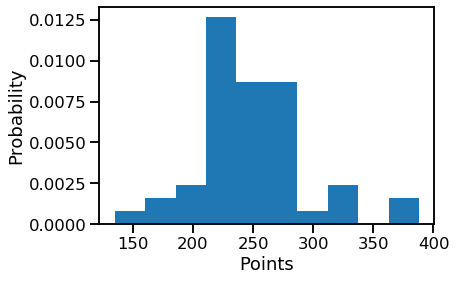

In [51]:
final_rewards = np.array(final_rewards)
plt.hist(final_rewards, normed=True)
plt.xlabel("Points")
plt.ylabel("Probability")

In [16]:
final_rewards.mean()

248.58

In [17]:
final_rewards.std()

45.26547912040698

In [25]:
df = pd.DataFrame.from_dict(hist_dict, orient='index')

In [26]:
df

,0,1,2,3,4,5,6,7,8,9,...,53,54,55,56,57,58,59,60,61,62
0,-257.666667,-0.047365,-0.057745,0.130948,0.408647,-0.320165,0.136147,-0.238766,-0.359421,-0.184304,...,0.194102,0.178946,0.193994,0.194403,0.131814,0.025684,0.106249,0.144265,0.019381,0.145921
1,-257.666667,-0.047365,-0.057745,0.130948,0.408647,-0.320165,0.136147,-0.238766,-0.359421,-0.184304,...,0.194102,0.178946,0.193994,0.194403,0.131814,0.025684,0.106249,0.144265,0.019381,0.145921
2,-267.666667,-0.335575,-0.048149,0.112616,0.450417,-0.161054,0.223898,-0.533736,-0.505337,-0.388933,...,0.195687,0.180800,0.193905,0.194613,0.131043,0.025938,0.106646,0.142037,0.019389,0.147149
3,-267.666667,-0.335575,-0.048149,0.112616,0.450417,-0.161054,0.223898,-0.533736,-0.505337,-0.388933,...,0.195687,0.180800,0.193905,0.194613,0.131043,0.025938,0.106646,0.142037,0.019389,0.147149
4,-267.666667,-0.335575,-0.048149,0.112616,0.450417,-0.161054,0.223898,-0.533736,-0.505337,-0.388933,...,0.195687,0.180800,0.193905,0.194613,0.131043,0.025938,0.106646,0.142037,0.019389,0.147149
5,-267.666667,-0.335575,-0.048149,0.112616,0.450417,-0.161054,0.223898,-0.533736,-0.505337,-0.388933,...,0.195687,0.180800,0.193905,0.194613,0.131043,0.025938,0.106646,0.142037,0.019389,0.147149
6,-267.666667,-0.335575,-0.048149,0.112616,0.450417,-0.161054,0.223898,-0.533736,-0.505337,-0.388933,...,0.195687,0.180800,0.193905,0.194613,0.131043,0.025938,0.106646,0.142037,0.019389,0.147149
7,-267.666667,-0.335575,-0.048149,0.112616,0.450417,-0.161054,0.223898,-0.533736,-0.505337,-0.388933,...,0.195687,0.180800,0.193905,0.194613,0.131043,0.025938,0.106646,0.142037,0.019389,0.147149
8,-267.666667,-0.335575,-0.048149,0.112616,0.450417,-0.161054,0.223898,-0.533736,-0.505337,-0.388933,...,0.195687,0.180800,0.193905,0.194613,0.131043,0.025938,0.106646,0.142037,0.019389,0.147149
9,-267.666667,-0.335575,-0.048149,0.112616,0.450417,-0.161054,0.223898,-0.533736,-0.505337,-0.388933,...,0.195687,0.180800,0.193905,0.194613,0.131043,0.025938,0.106646,0.142037,0.019389,0.147149


Text(0, 0.5, 'Reward obtained')

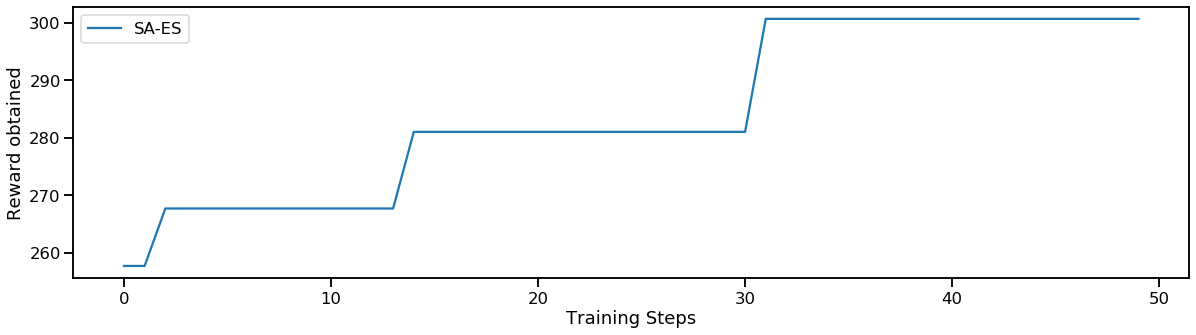

In [37]:
hist_reward = -df[0]
ax = hist_reward.plot(figsize=(20, 5))
ax.legend(['SA-ES'])
plt.xlabel("Training Steps")
plt.ylabel("Reward obtained")

Text(0.5, 0, 'Training Steps')

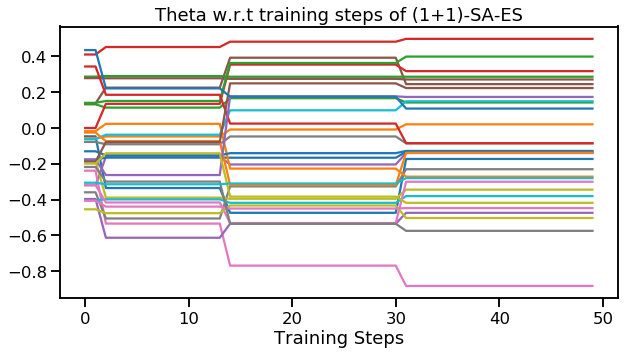

In [43]:
ax = df[list(range(1, 32))].plot(title="Theta w.r.t training steps of (1+1)-SA-ES",  figsize=(10, 5), legend = False)
plt.xlabel("Training Steps")

Text(0, 0.5, 'Sigma')

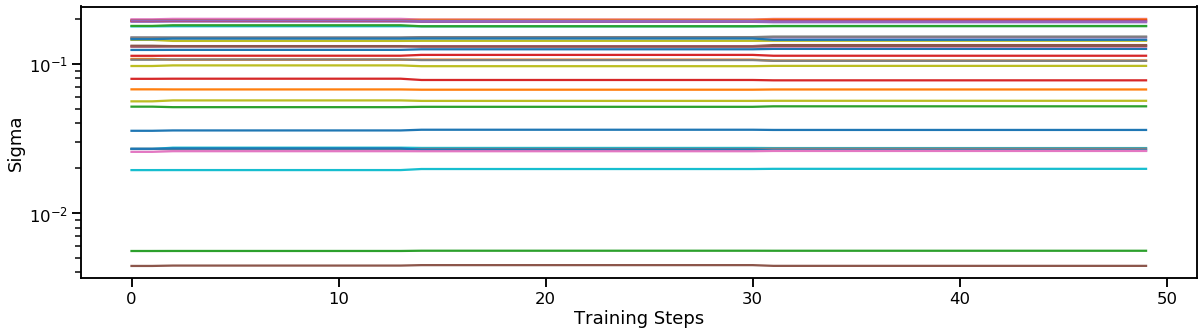

In [39]:
ax = df[list(range(32, 63))].plot(logy=True, figsize=(20, 5), legend = False)
plt.xlabel("Training Steps")
plt.ylabel("Sigma")